# Long Short Term Memory

In [1]:
import numpy as np
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv 
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM  
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

## Human Activity Recognition Using Smartphones Data Set

We will be using machine learning to preform Human Activity Recognition (HAR) for the following 6 activities:

1. WALKING
2. WALKING_UPSTAIRS
3. WALKING_DOWNSTAIRS
4. SITTING
5. STANDING
6. LAYING

To do this, we will analyze 9 signals collected from people as they preformed these activities. 30 participants wore a Samsung Galaxy S II. Using its embedded accelerometer and gyroscope, 3-axial linear acceleration and 3-axial angular velocity were recorded at a constant rate of 50Hz.

The experiments have been video-recorded to label the data manually. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data. Note: it is important that all of a patients activities were recorded in either the training or testing sets and not split between the 2.

The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width sliding windows of 2.56 sec and 50% overlap (128 readings/window). The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. From each window, a vector of features was obtained by calculating variables from the time and frequency domain. See 'features_info.txt' for more details.

For more information, please consult the README file in the data folder or visit: https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones


## Loading the Data

To load this function, we import `utils`. This is a python file saved in the same directory as the file we are working in, and it has some helper functions for loading the data. We need these helper files because as we will see this data is more complicated than some of the other classification problems we have discussed.

In [17]:
from utils import *

Use the model to load the training and testing data sets

In [18]:
trainX, trainy, testX, testy = load_dataset()

Below, we print the shape of each part of the partitioned data set we created above.

In [4]:
# TODO: Print the shape of each part of the data set (i.e. featues and labels for testing and training)
print('Training Features Shape:', trainX.shape  )
print('Training Labels Shape:', trainy.shape  )
print('Testing Features Shape:',  testX.shape )
print('Testing Labels Shape:', testy.shape  )

Training Features Shape: (7352, 128, 9)
Training Labels Shape: (7352, 1)
Testing Features Shape: (2947, 128, 9)
Testing Labels Shape: (2947, 1)


## Investigate the Data

### Class Balance
As we have seen, it is important to understand the class balance of a data set. In the case of a HAR classification problem, we are interested in knowing how many examples of each type of activity we have in the data set. In the following cell, we explore this. Additionally, this is the first multiclass classification problem that we will be working on that doesn't have perfectly balanced data.

In [5]:
# convert the numpy array into a dataframe
df = DataFrame(trainy) 
# group data by the class value and calculate the number of rows
counts = df.groupby(0).size()
# retrieve raw rows
counts = counts.values
# summarize
print('Training Data Set:')
for i in range(len(counts)):
    percent = counts[i] / len(df) * 100
    print('Class=%d, total=%d, percentage=%.3f' % (i+1, counts[i], percent))

Training Data Set:
Class=1, total=1226, percentage=16.676
Class=2, total=1073, percentage=14.595
Class=3, total=986, percentage=13.411
Class=4, total=1286, percentage=17.492
Class=5, total=1374, percentage=18.689
Class=6, total=1407, percentage=19.138


### Ploting a Single Activity

Since we have time serise data, an important check is plotting all of the data in time. We can do this for a signle subject at a time to get a sense of what the signals may look like. The function below will make a plot for the value of each signal throughout time as well as a plot for which activitiy is occuring.

In [7]:
# plot the data for one subject
def plot_subject(X, y):
    plt.figure()
    # determine the total number of plots
    n, off = X.shape[2] + 1, 0
    # plot total acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('total acc '+str(i), y=0, loc='left')
        off += 1
    # plot body acc
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body acc '+str(i), y=0, loc='left')
        off += 1
    # plot body gyro
    for i in range(3):
        plt.subplot(n, 1, off+1)
        plt.plot(to_series(X[:, :, off]))
        plt.title('body gyro '+str(i), y=0, loc='left')
        off += 1
    # plot activities
    plt.subplot(n, 1, n)
    plt.plot(y)
    plt.title('activity', y=0, loc='left')
    plt.show()

The `to_series` function we see above is used to account for the fact that there is a 50% overlap in the signals between time points. This function, is used to remove that overlap. If you want to explore how that function works, you can look in `utils.py` to see it, and some of the other functions we have been relying on for loading our data.

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
There are 21 subjects
(341, 128, 9) (341, 1)


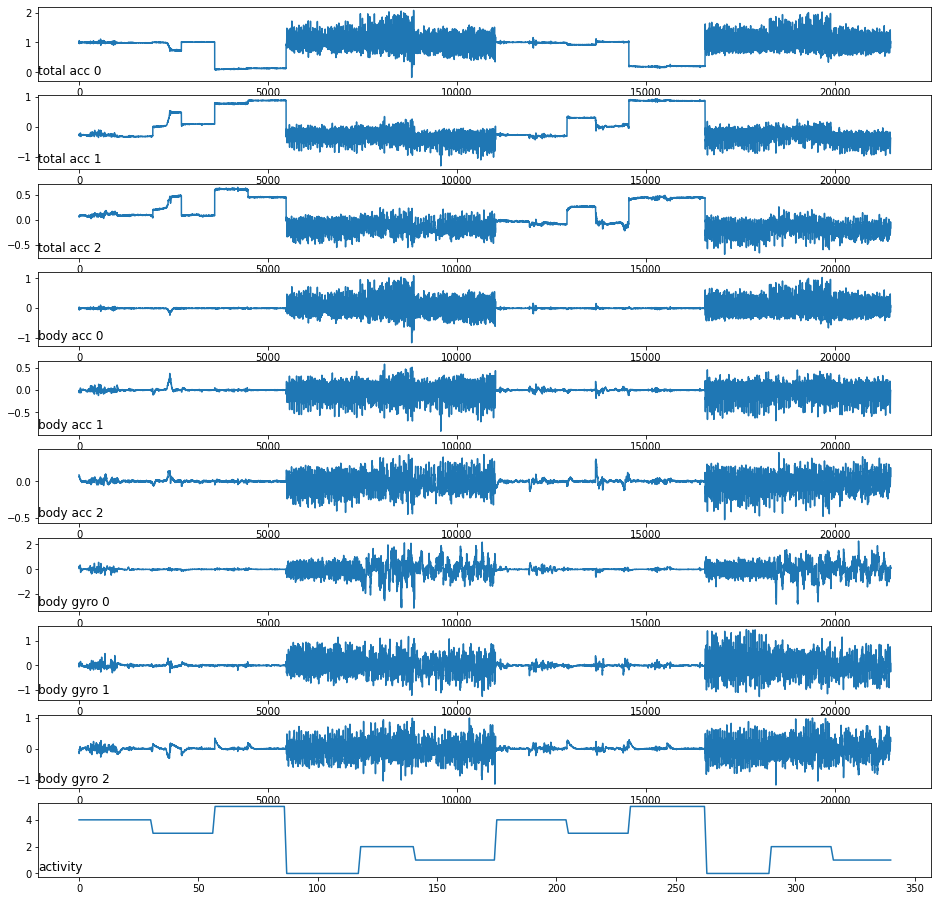

In [9]:
# The subjects are the patients we will be loading in from the training set
sub_map = load_file('data/train/subject_train.txt')

# This loads in the list of unique subjects
train_subjects = np.unique(sub_map)
print(train_subjects)

# TODO: Fill in this line to print the number of subjects
print('There are',  len(train_subjects)  ,'subjects')

# get the data for one subject
# TODO: This value must be with in the range of train_subjects
sub_id = train_subjects[  1   ]

# Load the features and labels for the subject
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)

# plot data for subject
plt.rcParams['figure.figsize'] = [16, 16]
plot_subject(subX, suby)

# Model Developement

In the next cell, we reformat the labels to be compatable with the `Sequential` model from `tensorflow`. This reformats the labels into One Hot Encodings, which is a different format than we used when generating the plots above.

In [19]:
trainy = to_categorical(trainy)
testy = to_categorical(testy)

In the next cell, we will build our network, parameterizing the size and activation function of each layer in the network. There are many parameters that we could change here, but because of the time and resources it will take to train, we will keep our model relatively simple during the session and only be varying which activation function we use. Information on these activation functions can be found at: https://keras.io/api/layers/activations/

In [20]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    
    # TODO: Set these parameters
    #       Note: please keep epochs < 5 during the session so it doesn't take too long to run your code
    epochs = 3
    batch_size = 64
    
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # TODO: Look at how the model is built
    model = Sequential()
    # LSTM layer
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    # TODO: fill in the activations as sigmoid, softmax, relu, tahn, or anything else from the link above
    model.add(Dense(100, activation=  'relu'   ))
    model.add(Dense(n_outputs, activation=  'sigmoid'   ))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In the cell below, we creat a function called `run_experiment`, its purpose is to go call the `evaluate_model` function multiple times to record and summarize its scores. It is important to note that this is NOT cross validation.

In [21]:
# run an experiment
def run_experiment(repeats=10):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        
        # Call the function we wrote abote
        # TODO: Fill in the parameters for that function
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#', r+1  , ': ', score  )
        scores.append(score)
    
    # summarize results
    # TODO: Fill out this code
    print('Mean Accuracy:',  np.mean(scores) )
    print('Standard Deviation in Accuracy:',  np.std(scores) )

Finally, we run the code in `run_experiment` by calling the function in the cell below.

In [22]:
run_experiment()

># 1 :  80.99762201309204
># 2 :  77.87580490112305
># 3 :  70.44451832771301
># 4 :  70.10518908500671
># 5 :  79.40278053283691
># 6 :  79.47064638137817
># 7 :  80.45470118522644
># 8 :  77.1632194519043
># 9 :  70.64811587333679
># 10 :  73.4645426273346
Mean Accuracy: 76.0027140378952
Standard Deviation in Accuracy: 4.171329764996405


This notebook is based on python code seen at these following links:
1. https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/
2. https://machinelearningmastery.com/how-to-model-human-activity-from-smartphone-data/